# Data Science Workflow

## Set Up the Jupyter Notebook for Analysis

Note: We have our package called swat - SAS Scripting Wrapper for Analytics Transfer - available on GitHub via pip install <br>

In [2]:
import swat
import os
import getpass

# Connect to CAS server
password = getpass.getpass()
s = swat.CAS("http://orange.orange-azure-nginx-5e15154f.unx.sas.com/cas-shared-default-http", username="sasadm", password=password)

# Define caslib
s.sessionprop.setsessopt(caslib='Public')

 ········


NOTE: 'Public' is now the active caslib.


+ Elapsed: 0.0474s, user: 0.0727s, sys: 0.0226s, mem: 1.58mb

## Access Data - CAS

In [3]:
# data file
indata = 'HMEQ_ID'
op = s.table.loadTable(path=str(indata).upper()+".sashdat", casout={"name":indata, "replace":True})

# CASTable view
castbl = s.CASTable(indata)

NOTE: Cloud Analytic Services made the file HMEQ_ID.sashdat available as table HMEQ_ID in caslib Public.


# Local data analysis

In [4]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Exploration and Preparation - Local

In [5]:
# Bring data locally
df = castbl.to_frame()

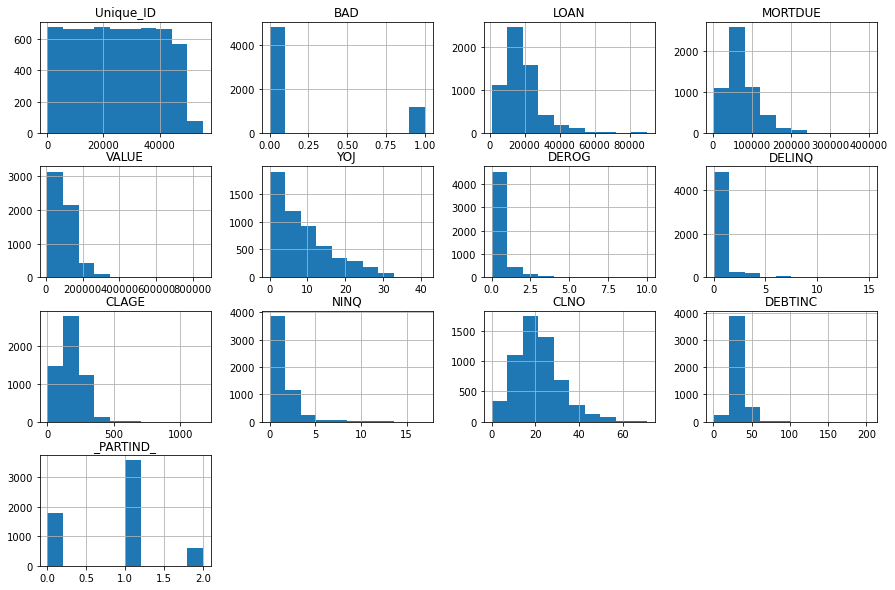

In [6]:
hists = df.hist(figsize = (15, 10))

### set variable shortcuts

In [7]:
# Define target variable
target = 'BAD'
id_col = 'Unique_ID'

# get categorical/numerical variables
input_vars = df.drop(target,axis=1).columns.values
kinds = np.array([dt.kind for dt in df.drop(target,axis=1).dtypes])

# Variable lists
categorical_vars = list(input_vars[kinds == 'O'])
numerical_vars = [i for i in list(input_vars[kinds != 'O']) if i not in [id_col,'_PARTIND_']]
input_vars = categorical_vars + numerical_vars
all_vars = categorical_vars + numerical_vars + [target]

### Prepare data for model

In [8]:
# Split into training and validation / target and inputs
X_train = df[df['_PARTIND_'] == 1].drop(['Unique_ID','_PARTIND_',target], axis = 1)
X_valid = df[df['_PARTIND_'] == 0].drop(['Unique_ID','_PARTIND_',target], axis = 1)
# X_test = df[df['_PARTIND_'] == 2].drop(['Unique_ID','_PARTIND_',target], axis = 1)
y_train = df[df['_PARTIND_'] == 1][target]
y_valid = df[df['_PARTIND_'] == 0][target]
# y_test = df[df['_PARTIND_'] == 2][target]

## Build model - Scikit-learn

In [9]:
# Define data pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_vars),
    ('cat', categorical_transformer, categorical_vars)])

ml_pipe = Pipeline(steps=[
('preprocessor', preprocessor),
('model', GradientBoostingClassifier(random_state=11))])

fit = ml_pipe.fit(X_train, y_train)

### Assess model

In [10]:
# put results in pandas dataframe
results_df = pd.DataFrame(dict(actual = y_valid, pred = ml_pipe.predict_proba(X_valid)[:,1]))
train_fit_df = pd.DataFrame(dict(actual = y_train, pred = ml_pipe.predict_proba(X_train)[:,1]))
# tests_df = pd.DataFrame(dict(actual = y_test, pred = ml_pipe.predict_proba(X_test)[:,1]))

# Predict and assess model
gb_y_score           = ml_pipe.predict(X_valid)
gb_misclassification = 1 - accuracy_score(y_valid, gb_y_score)
gb_confusion_matrix  = confusion_matrix(y_valid, gb_y_score)

# Add Python model results to CAS to assess
pytbl = s.upload_frame(results_df, casout=dict(name='GBT_sklearn_predictions', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GBT_SKLEARN_PREDICTIONS in caslib Public.
NOTE: The table GBT_SKLEARN_PREDICTIONS has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [11]:
gb_misclassification

0.10067114093959728

# Data Analysis on CAS

In [12]:
# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'regression', 'neuralNet', 'svm', 'astore','autotune']
actions = [s.loadactionset(i) for i in actionsets]

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.


In [13]:
s.dataStep.runCode(                   
   code='''data "HMEQ_ID";
   length "BAD_CONVERTED"n varchar(16);
   set "HMEQ_ID";
   format "BAD_CONVERTED"n $CHAR16.;
   "BAD_CONVERTED"n= PUT("BAD"n,BEST16.);
   run;''')
castbl.table.altertable(columns=[{'name':'BAD','drop':True},{'name':'BAD_CONVERTED','rename':'BAD','label':'Default on Loan'}])

+ Elapsed: 0.00824s, user: 0.00573s, sys: 0.00998s, mem: 0.956mb

## Data Exploration and Preparation - CAS

In [14]:
castbl.head()

,BAD,Unique_ID,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,_PARTIND_
0,0,47506.0,16500.0,51758.0,138693.0,DebtCon,Other,2.0,0.0,0.0,283.069841,5.0,43.0,39.716771,0.0
1,0,47606.0,16500.0,52030.0,158296.0,DebtCon,ProfExe,20.0,0.0,0.0,218.539266,0.0,27.0,22.484792,2.0
2,1,47706.0,16500.0,43223.0,46925.0,DebtCon,Other,10.0,0.0,0.0,178.002383,4.0,20.0,40.206334,1.0
3,0,47806.0,16500.0,44946.0,64918.0,HomeImp,Other,25.0,0.0,0.0,247.278408,0.0,14.0,24.357950,1.0
4,0,47906.0,16500.0,48674.0,73720.0,DebtCon,ProfExe,17.0,0.0,0.0,186.473071,0.0,23.0,38.373608,1.0


<AxesSubplot:>

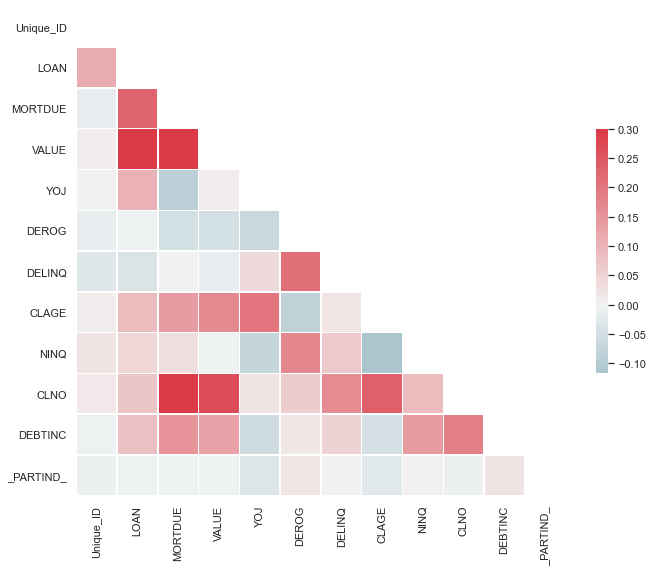

In [15]:
# Compute correlation matrix
corr = castbl.corr()

# Visualize with Seaborn
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Build models - CAS

In [16]:
import collections

# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
models['svm'] = 'Support Vector Machine'

# Impute missing values
castbl.dataPreprocess.impute(
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = categorical_vars + numerical_vars,
    copyAllVars       = True,
    casOut            = dict(name = 'hmeq_imputed', replace = True)
)
castbl_imp = s.CASTable('hmeq_imputed')

# Set key-word argument shortcuts (common model inputs)
## For models that can handle missing values (decision tree, gradient boosting)
params = dict(
    table    = dict(name = indata, where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = categorical_vars + numerical_vars, 
    nominals = categorical_vars,
)

## For models that can't have missing values (neural network, support vector machine)
casinfo = castbl_imp.columninfo()['ColumnInfo']
imp_params = dict(
    table    = dict(name = 'hmeq_imputed', where = '_PARTIND_ = 1'), 
    target   = target, 
    inputs   = [x for x in list(casinfo['Column']) if x != target and ('IMP_' in x)], 
    nominals = [x for x in list(casinfo[casinfo.Type == 'varchar']['Column']) if x != target and ('IMP' in x)],
)

### Decision Tree - CAS

In [17]:
dt = s.decisionTree.dtreeTrain(**params, varImp = True, casOut = dict(name = 'dt_model', replace = True))

### Gradient Boosting - CAS

In [18]:
gbt = s.decisionTree.gbtreeTrain(**params, seed = 1, casOut = dict(name = 'gbt_model', replace = True), saveState=dict(name = 'gradboost_model', replace = True))

NOTE: 972769 bytes were written to the table "gradboost_model" in the caslib "Public".


### Neural Network - CAS

In [19]:
nn = s.neuralNet.annTrain(**imp_params, seed = 999, casOut = dict(name = 'nn_model', replace = True))

### Support Vector Machine - CAS

In [20]:
svm = s.svm.svmTrain(**imp_params, seed = 999, kernel = 'polynomial', printtarget=True, id = ['_PARTIND_', 'Unique_ID'], savestate = dict(name = 'svm_model', replace = True))

NOTE: Reset degree to 2 for polynomial kernel.
NOTE: SVM training is activated.
NOTE: 11603 bytes were written to the table "svm_model" in the caslib "Public".


# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [21]:
def score_model(model):
    score = dict(
        table      = 'hmeq_imputed',
        modelTable = model + '_model',
        copyVars   = [target, '_PARTIND_', 'Unique_ID'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))
### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))
### Neural Network
s.neuralNet.annScore(**score_model('nn'))
### Support Vector Machine
castbl_imp.astore.score(rstore = 'svm_model', out = dict(name = '_scored_svm_1', replace = True))


### Create standardized prediction column
for i in range(len(models)-1):
    s.dataStep.runCode('''
        data _scored_''' + list(models)[i] + '''; 
            set _scored_''' + list(models)[i] + ''';
            if _''' + list(models)[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
        run;
    ''')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:71
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:69


In [22]:
joined = s.CASTable('_scored_svm_1').merge(castbl_imp[['Unique_ID','BAD']],on='Unique_ID')
s.dropTable('_scored_svm', quiet=True)
s.table.altertable(name = joined.name, rename='_scored_svm')

+ Elapsed: 0.0114s, user: 0.00918s, sys: 0.0108s, mem: 0.902mb

## Assess the Performance - CAS/Python

In [23]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_PARTIND_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model'] = list(models.values())[i]
    roc_df = pd.concat([roc_df, tmp.ROCInfo])

## Compare Misclassification & ROC Curves - CAS/Python

In [24]:
# Assess the Python model using CAS
python_assess = pytbl.percentile.assess(
    inputs   = 'pred',      
    response = 'actual',
    event    = '1',   
)
python_assess.ROCInfo['Model'] = 'Gradient Boosting - sklearn'
roc_df['Model'] = roc_df['Model'] + ' - CAS'
roc_df = pd.concat([roc_df, python_assess.ROCInfo])
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
1,Gradient Boosting - CAS,0.098993
4,Gradient Boosting - sklearn,0.100671
0,Decision Tree - CAS,0.123602
3,Support Vector Machine - CAS,0.156600
2,Neural Network - CAS,0.159955


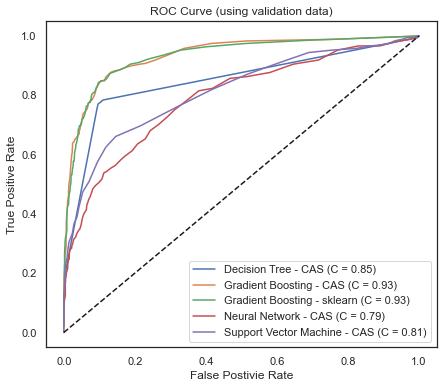

In [25]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)');

## Automated Machine Learning

## AutoML - CAS

In [111]:
s.loadactionset('dataSciencePilot')
trans_out = dict(name = 'trans_out', replace=True)
feat_out = dict(name = 'feat_out', replace=True)
pipeline_out = dict(name = 'pipeline_out', replace=True)
#save_state_out = dict(name = 'save_state_out', replace=True)
automl_model = dict(name = 'automl_model', replace=True) 

NOTE: Added action set 'dataSciencePilot'.


In [112]:
s.dataSciencePilot.dsAutoMl(table=castbl, target=target,
                            modelTypes=["DECISIONTREE", "FOREST", "GRADBOOST", "NEURALNET"], 
                            transformationOut = trans_out,
                            featureOut = feat_out,
                            pipelineOut = pipeline_out,
                            saveState = automl_model)

NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'autotune'.
NOTE: Early stopping is activated; '

,Descr,Value
0,Number of Tree Nodes,29.000000
1,Max Number of Branches,2.000000
2,Number of Levels,5.000000
3,Number of Leaves,15.000000
4,Number of Bins,100.000000
5,Minimum Size of Leaves,10.000000
6,Maximum Size of Leaves,2195.000000
7,Number of Variables,10.000000
8,Confidence Level for Pruning,0.250000
9,Number of Observations Used,5960.000000


In [113]:
s.fetch(table='pipeline_out', to=3)

,PipelineId,ModelType,MLType,Objective,ObjectiveType,Target,NFeatures,Feat1Id,Feat1IsNom,Feat2Id,...,Feat9Id,Feat9IsNom,Feat10Id,Feat10IsNom,Feat11Id,Feat11IsNom,Feat12Id,Feat12IsNom,Feat13Id,Feat13IsNom
0,3.0,binary classification,gradBoost,0.088367,MCE,BAD,13.0,32.0,1.0,34.0,...,19.0,0.0,42.0,1.0,16.0,1.0,15.0,1.0,43.0,1.0
1,11.0,binary classification,gradBoost,0.092282,MCE,BAD,10.0,32.0,1.0,35.0,...,19.0,0.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,binary classification,forest,0.098434,MCE,BAD,13.0,32.0,1.0,34.0,...,19.0,0.0,42.0,1.0,16.0,1.0,15.0,1.0,43.0,1.0


# Register Model

In [26]:
import sasctl
from mm_utils import *

# Model Registry Connection
MODEL_REGISTRY_META = read_yaml('model_registry_config.yaml')
SERVER = MODEL_REGISTRY_META['connection']['server']
USER= 'sasadm'

PROJECT_NAME = MODEL_REGISTRY_META['modelrepository_meta']['project_name']
REPOSITORY = MODEL_REGISTRY_META['modelrepository_meta']['repository']

## Add model to repository - CAS

In [27]:
from sasctl import Session
from sasctl.tasks import register_model

astore = s.CASTable('gradboost_model')
with Session(hostname=SERVER, username=USER, password=password, verify_ssl=False):
    register_model(astore, 'SAS Viya GBT swat', PROJECT_NAME)

C:\Users\frascb\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'orange.orange-azure-nginx-5e15154f.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _77839F37590049A0A6FE1D1CB.sashdat in caslib ModelStore.


## Add model to repository - sklearn

### Initialize folder & save pickle

In [28]:
import sasctl.pzmm as pzmm

MODEL = ml_pipe
MODEL_PREFIX = 'Sklearn_GBT' #No spaces allowed
MODEL_TYPE = 'Pipeline Gradient Boosting'

y_pred = results_df['pred']
targetValue = "1"

ZIP_FOLDER = init_folder(MODEL_PREFIX)
pzmm.PickleModel.pickleTrainedModel(None, MODEL, MODEL_PREFIX, ZIP_FOLDER)

### Write requirement.txt

In [29]:
# write_requirements(WRK_DIR, 'requirements.txt')

### Write Metadata files (optional)

In [30]:
JSONFiles = pzmm.JSONFiles()
#write input.json
JSONFiles.writeVarJSON(df[input_vars], isInput=True, jPath=ZIP_FOLDER)

In [31]:
NAMES=['P_BAD0', 'P_BAD1', 'EM_CLASSIFICATION', 'EM_EVENTPROBABILITY']
LABELS=['0', '1']
EVENTPROB=0.5
outputVar = get_output_variables(NAMES, LABELS, EVENTPROB)

#write output.json
JSONFiles.writeVarJSON(outputVar, isInput=False, jPath=ZIP_FOLDER)

In [32]:
JSONFiles.writeModelPropertiesJSON(modelName=MODEL_PREFIX,
                                   modelDesc='Sklearn classifier',
                                   targetVariable=target,
                                   modelType=MODEL_TYPE,
                                   modelPredictors=input_vars,
                                   targetEvent=targetValue,
                                   numTargetCategories=2,
                                   eventProbVar='EM_EVENTPROBABILITY',
                                   jPath=ZIP_FOLDER,
                                   modeler='sasadm')

In [33]:
JSONFiles.writeFileMetadataJSON(MODEL_PREFIX, jPath=ZIP_FOLDER)

# Evaluation data
JSONFiles = pzmm.JSONFiles()

JSONFiles.calculateFitStat(
    validateData=[np.array(y_valid.astype(int)), np.array(y_pred)],
    trainData=[np.array(y_train.astype(int)), np.array(train_fit_df["pred"])],
    testData=None,
    jPath=ZIP_FOLDER)

JSONFiles.generateROCLiftStat(
    targetName=target,
    targetValue=targetValue,
    swatConn=s,
    validateData=pd.DataFrame({'col1': y_valid.astype(int),'col2': y_pred}),
    trainData=pd.DataFrame({'col1': y_train.astype(int), 'col2': train_fit_df["pred"]}),
    testData=None,
    jPath=ZIP_FOLDER)

NOTE: Added action set 'percentile'.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCOREDVALUES in caslib Public.
NOTE: The table SCOREDVALUES has been created in caslib Public from binary data uploaded to Cloud Analytic Services.


In [34]:
# Score code
# models_path = 'models'
# model_path = models_path + '/' + MODEL_PREFIX
# zipFolder = Path.cwd() / 'models'
# PROJECT_ID = '7edebcbd-0df2-408b-803f-6f46761fdea4'
# server_pickle_path = '/tmp/' + PROJECT_ID + '/' + MODEL_PREFIX + '.pickle'
threshold = 0.5

vars_string = str(input_vars)
remove_characters = ["'", "[", "]"]

for character in remove_characters:
    vars_string = vars_string.replace(character, "")

In [35]:
scoringstring = '''
import pickle
import pandas as pd
import settings
                            
global _thisModelFit

with open(settings.pickle_path + '{0}', 'rb') as _pFile:
    _thisModelFit = pickle.load(_pFile)

def scoreSklearn_GBT({1}):
    "Output: EM_EVENTPROBABILITY, EM_CLASSIFICATION"
    
    try:
        _thisModelFit
    except NameError:

        with open(settings.pickle_path + '{0}', 'rb') as _pFile:
            _thisModelFit = pickle.load(_pFile)
    
    inputArray = pd.DataFrame([[{1}]], columns = {2})
    
    prediction = _thisModelFit.predict_proba(inputArray)

    EM_EVENTPROBABILITY = float(prediction[:,1])

    if (EM_EVENTPROBABILITY >= {3}):
        EM_CLASSIFICATION = '1'
    else:
        EM_CLASSIFICATION = '0'

    return(EM_EVENTPROBABILITY, EM_CLASSIFICATION)
'''.format(MODEL_PREFIX + '.pickle',vars_string, str(input_vars),str(threshold))

In [36]:
text_file = open(ZIP_FOLDER + '/' + MODEL_PREFIX + 'Score.py', "w")
n = text_file.write(scoringstring)
text_file.close()

In [37]:
#Zip folder
pzmm.ZipModel.zipFiles(ZIP_FOLDER,MODEL_PREFIX)

In [38]:
zPath = ZIP_FOLDER + "/" + MODEL_PREFIX + '.zip'

with Session("http://orange.orange-azure-nginx-5e15154f.unx.sas.com", "sasadm", password, verify_ssl=False):
    zipfile = open(zPath, 'rb')
    model_repository.import_model_from_zip(MODEL_PREFIX,
                                           "Credit Scoring",
                                           file=zipfile,
                                           version='latest')
    zipfile.close()

In [40]:
!pip show sasctl

Name: sasctl
Version: 1.5.9
Summary: SAS Viya REST Client
Home-page: https://github.com/sassoftware/python-sasctl/
Author: SAS
Author-email: None
License: Apache v2.0
Location: c:\users\frascb\appdata\local\continuum\anaconda3\lib\site-packages
Requires: pandas, scikit-learn, requests, six
Required-by: 


In [71]:
I = pzmm.ImportModel()
with Session("http://dach-viya4-k8s", "viyademo01", password, verify_ssl=False):
    I.pzmmImportModel(ZIP_FOLDER, MODEL_PREFIX, 'OpenSource', df.drop(['Unique_ID','_PARTIND_',target], axis = 1), df[target], '{}.predict({})')

In [62]:
inputDF = df.drop(['Unique_ID','_PARTIND_',target], axis = 1)

In [63]:
inputVarList = list(inputDF.columns)
for name in inputVarList:
    if not str(name).isidentifier():
        raise SyntaxError('Invalid column name in inputDF. Columns must be ' +
                          'valid as Python variables.')
newVarList = list(inputVarList)
inputDtypesList = list(inputDF.dtypes)

In [64]:
print(inputVarList, newVarList, inputDtypesList)

['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'] ['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'] [dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


In [65]:
inputArray = pd.DataFrame([[LOAN, MORTDUE, VALUE, REASON, JOB, YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC]],
                                  columns=['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
                                  dtype=float)

NameError: name 'LOAN' is not defined